In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
plt.style.use("seaborn")

In [2]:
df = pd.read_excel("project data/EAI6010Project.xlsx", sheet_name="RiskZoneData")

## Loading Geospatial Massachusetts data:

In [3]:
USA_geo = gpd.read_file("project data/mass_zcta/cb_2019_us_zcta510_500k.shp")

In [4]:
USA_geo["ZCTA5CE10"] = USA_geo["ZCTA5CE10"].map(lambda x: int(x))

In [5]:
zips = df["ZipCode"]
MA_geo = USA_geo[USA_geo["ZCTA5CE10"].isin(zips)]

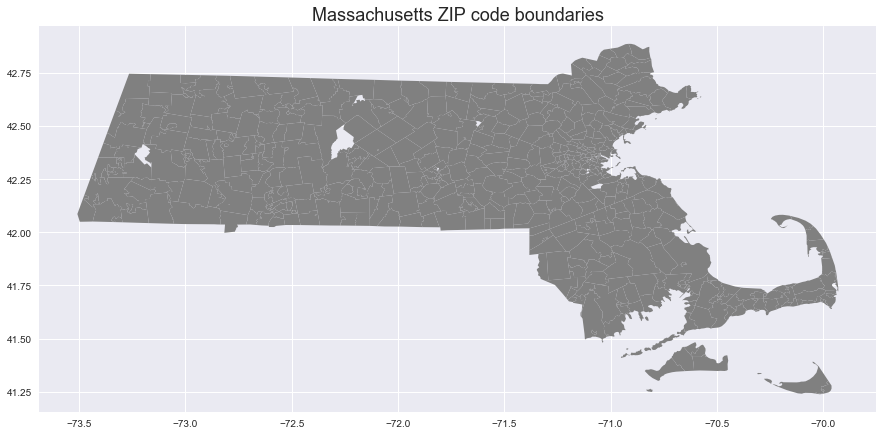

In [31]:
fig, ax = plt.subplots(1, figsize=(15, 15))
ma_plot = MA_geo.plot(ax=ax, color="gray")
plt.title("Massachusetts ZIP code boundaries", fontsize=18)
plt.show()

In [21]:
working_df = gpd.GeoDataFrame(pd.merge(left=df, right=MA_geo, left_on="ZipCode", right_on="ZCTA5CE10"))

## Blue Bikes data processing:

#### [Official open source data source](https://www.bluebikes.com/system-data)

In [10]:
bb_df = pd.read_csv("project data/202003-bluebikes-tripdata.csv")

In [11]:
bb_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,366,2020-03-01 00:01:09.0060,2020-03-01 00:07:15.2360,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,446,700 Commonwealth Ave.,42.349609,-71.103915,5566,Customer,1969,0
1,367,2020-03-01 00:01:10.9500,2020-03-01 00:07:18.1970,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,446,700 Commonwealth Ave.,42.349609,-71.103915,4113,Customer,1969,0
2,120,2020-03-01 00:01:50.3890,2020-03-01 00:03:51.3510,372,Boylston St at Exeter St,42.349589,-71.079468,16,Back Bay T Stop - Dartmouth St at Stuart St,42.348074,-71.076570,4854,Subscriber,1960,1
3,646,2020-03-01 00:01:57.2720,2020-03-01 00:12:43.5950,328,Grove St at Community Path,42.396387,-71.120113,115,Porter Square Station,42.387995,-71.119084,3441,Subscriber,1994,1
4,424,2020-03-01 00:02:03.9240,2020-03-01 00:09:08.3250,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,5497,Subscriber,1962,2


In [18]:
from functools import partial
from shapely import geometry

def get_point(row, lat_name, long_name):
    return geometry.Point(row[long_name], row[lat_name])

get_start = partial(get_point, lat_name="start station latitude", long_name="start station longitude")
get_end = partial(get_point, lat_name="end station latitude", long_name="end station longitude")

bb_df["start_station_point"] = bb_df.apply(get_start, axis=1)
bb_df["end_station_point"] = bb_df.apply(get_end, axis=1)

In [ ]:
def calculate_trips_for_poly(bb_row, zip_poly):
    start_trip = bb_row.start_station_point.within(zip_poly)
    end_trip = bb_row.end_station_point.within(zip_poly)
    return any([start_trip, end_trip])
    
def find_number_of_trips(zone_row):
    trips = bb_df.apply(lambda x: calculate_trips_for_poly(x, zone_row.geometry), axis=1).value_counts()
    try:
        return trips[1]
    except KeyError:
        return 0

    
working_df["number_of_bb_trips"] = working_df.apply(find_number_of_trips, axis=1)

In [ ]:
working_df[["ZipCode", "number_of_bb_trips"]].to_csv("project data/bb_trips.csv")

## Public transport data processing:
#### [Bus stops MBTA public available dataset](https://docs.digital.mass.gov/dataset/massgis-data-mbta-bus-routes-and-stops)
#### [Rapid Transit stops MBTA public available dataset](https://maps-massgis.opendata.arcgis.com/datasets/a9e4d01cbfae407fbf5afe67c5382fde_0)

### Bus stops data:

In [24]:
mbta = gpd.read_file("project data/mbtabus/MBTABUSSTOPS_PT.shp")
mbta = mbta.to_crs(epsg=4326)

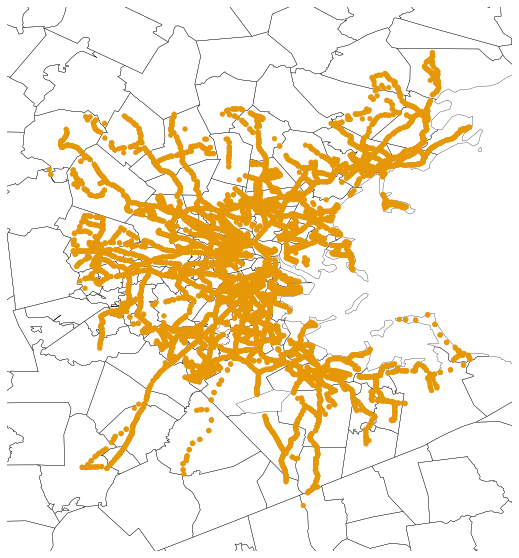

In [81]:
import geoplot


ax = geoplot.polyplot(MA_geo, figsize=(15, 10))
geoplot.pointplot(mbta, ax=ax, color="#e59706")
plt.show()

### Rapid transit stops data:

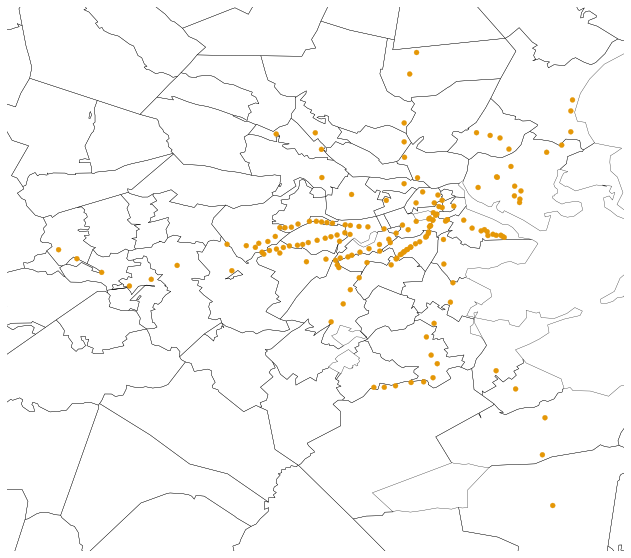

In [84]:
import geoplot


ax = geoplot.polyplot(MA_geo, figsize=(15, 10))
geoplot.pointplot(mbta_rapid_transit, ax=ax, color="#e59706")
plt.show()

In [82]:
mbta_rapid_transit = gpd.read_file("project data/mbta_rapid_transit/MBTA_NODE.shp")
mbta_rapid_transit = mbta_rapid_transit.to_crs(epsg=4326)

In [83]:
def stop_within_poly(bs_row, zip_poly):
    return bs_row.geometry.within(zip_poly)
    
    
def find_number_of_stops(zone_row, mbta_df):
    stops = mbta_df.apply(lambda x: stop_within_poly(x, zone_row.geometry), axis=1).value_counts()
    print(f"Counted for {zone_row.County} {zone_row.City} {zone_row.ZipCode}")
    try:
        n_stops =stops[1]
    except KeyError:
        n_stops = 0
        
    print(n_stops)
    return n_stops

working_df["number_of_bus_stops"] = working_df.apply(lambda x: find_number_of_stops(x, mbta), axis=1)
working_df["number_of_other_stops"] = working_df.apply(lambda x: find_number_of_stops(x, mbta_rapid_transit), axis=1)

Counted for Hampden Agawam 1001
0
Counted for Hampshire Amherst 1002
0
Counted for Hampshire Amherst 1003
0
Counted for Worcester Barre 1005
0
Counted for Hampshire Belchertown 1007
0
Counted for Hampden Blandford 1008
0
Counted for Hampden Bondsville 1009
0
Counted for Hampden Brimfield 1010
0
Counted for Hampden Chester 1011
0
Counted for Hampshire Chesterfield 1012
0
Counted for Hampden Chicopee 1013
0
Counted for Hampden Chicopee 1020
0
Counted for Hampden Chicopee 1022
0
Counted for Hampshire Cummington 1026
0
Counted for Hampshire Easthampton 1027
0
Counted for Hampden East Longmeadow 1028
0
Counted for Berkshire East Otis 1029
0
Counted for Hampden Feeding Hills 1030
0
Counted for Worcester Gilbertville 1031
0
Counted for Hampshire Goshen 1032
0
Counted for Hampshire Granby 1033
0
Counted for Hampden Granville 1034
0
Counted for Hampshire Hadley 1035
0
Counted for Hampden Hampden 1036
0
Counted for Worcester Hardwick 1037
0
Counted for Hampshire Hatfield 1038
0
Counted for Hamps

Counted for Worcester Worcester 1610
0
Counted for Worcester Cherry Valley 1611
0
Counted for Worcester Paxton 1612
0
Counted for Middlesex Framingham 1701
0
Counted for Middlesex Framingham 1702
0
Counted for Middlesex Village Of Nagog Woods 1718
0
Counted for Middlesex Boxborough 1719
0
Counted for Middlesex Acton 1720
0
Counted for Middlesex Ashland 1721
0
Counted for Middlesex Bedford 1730
59
Counted for Middlesex Hanscom Afb 1731
0
Counted for Worcester Bolton 1740
0
Counted for Middlesex Carlisle 1741
0
Counted for Middlesex Concord 1742
0
Counted for Worcester Fayville 1745
0
Counted for Middlesex Holliston 1746
0
Counted for Worcester Hopedale 1747
0
Counted for Middlesex Hopkinton 1748
0
Counted for Middlesex Hudson 1749
0
Counted for Middlesex Marlborough 1752
0
Counted for Middlesex Maynard 1754
0
Counted for Worcester Mendon 1756
0
Counted for Worcester Milford 1757
0
Counted for Middlesex Natick 1760
0
Counted for Middlesex Sherborn 1770
0
Counted for Worcester Southboroug

Counted for Middlesex Arlington 2476
82
Counted for Middlesex Belmont 2478
71
Counted for Norfolk Wellesley Hills 2481
0
Counted for Norfolk Wellesley 2482
0
Counted for Norfolk Needham 2492
9
Counted for Middlesex Weston 2493
0
Counted for Norfolk Needham Heights 2494
24
Counted for Barnstable Buzzards Bay 2532
0
Counted for Barnstable Cataumet 2534
0
Counted for Dukes Chilmark 2535
0
Counted for Barnstable East Falmouth 2536
0
Counted for Barnstable East Sandwich 2537
0
Counted for Plymouth East Wareham 2538
0
Counted for Dukes Edgartown 2539
0
Counted for Barnstable Falmouth 2540
0
Counted for Barnstable Buzzards Bay 2542
0
Counted for Barnstable Woods Hole 2543
0
Counted for Barnstable Monument Beach 2553
0
Counted for Nantucket Nantucket 2554
0
Counted for Barnstable North Falmouth 2556
0
Counted for Dukes Oak Bluffs 2557
0
Counted for Plymouth Onset 2558
0
Counted for Barnstable Pocasset 2559
0
Counted for Barnstable Sagamore 2561
0
Counted for Barnstable Sagamore Beach 2562
0
Co

Counted for Franklin Buckland 1338
0
Counted for Franklin Charlemont 1339
0
Counted for Franklin Colrain 1340
0
Counted for Franklin Conway 1341
0
Counted for Franklin Deerfield 1342
0
Counted for Berkshire Drury 1343
0
Counted for Franklin Erving 1344
0
Counted for Franklin Heath 1346
0
Counted for Franklin Lake Pleasant 1347
0
Counted for Franklin Millers Falls 1349
0
Counted for Franklin Monroe Bridge 1350
0
Counted for Franklin Montague 1351
0
Counted for Franklin Gill 1354
0
Counted for Franklin New Salem 1355
0
Counted for Franklin Northfield 1360
0
Counted for Franklin Orange 1364
0
Counted for Worcester Petersham 1366
0
Counted for Franklin Rowe 1367
0
Counted for Worcester Royalston 1368
0
Counted for Franklin Shelburne Falls 1370
0
Counted for Franklin South Deerfield 1373
0
Counted for Franklin Sunderland 1375
0
Counted for Franklin Turners Falls 1376
0
Counted for Franklin Warwick 1378
0
Counted for Franklin Wendell 1379
0
Counted for Worcester Fitchburg 1420
0
Counted for 

Counted for Suffolk Boston 2124
4
Counted for Suffolk Boston 2125
2
Counted for Suffolk Mattapan 2126
1
Counted for Suffolk Boston 2127
2
Counted for Suffolk Boston 2128
11
Counted for Suffolk Charlestown 2129
2
Counted for Suffolk Jamaica Plain 2130
6
Counted for Suffolk Roslindale 2131
0
Counted for Suffolk West Roxbury 2132
0
Counted for Suffolk Allston 2134
4
Counted for Suffolk Brighton 2135
7
Counted for Suffolk Hyde Park 2136
0
Counted for Middlesex Cambridge 2138
1
Counted for Middlesex Cambridge 2139
1
Counted for Middlesex Cambridge 2140
2
Counted for Middlesex Cambridge 2141
1
Counted for Middlesex Cambridge 2142
1
Counted for Middlesex Somerville 2143
0
Counted for Middlesex Somerville 2144
1
Counted for Middlesex Somerville 2145
1
Counted for Middlesex Malden 2148
2
Counted for Middlesex Everett 2149
0
Counted for Suffolk Chelsea 2150
4
Counted for Suffolk Revere 2151
3
Counted for Suffolk Winthrop 2152
0
Counted for Middlesex Medford 2155
1
Counted for Suffolk Boston 2163

In [ ]:
working_df[["number_of_other_stops", "ZipCode"]].to_csv("project data/other_stops.csv")
working_df[["ZipCode", "bus_stops"]].to_csv("project data/working_df_bs.csv")

## Park data processing:
#### [Massachusetts Park list](https://www.mass.gov/guides/alphabetical-list-of-massachusetts-state-parks)

In [85]:
import requests
from bs4 import BeautifulSoup

In [86]:
page = requests.get("https://www.mass.gov/guides/alphabetical-list-of-massachusetts-state-parks")
soup = BeautifulSoup(page.text, 'html.parser')

park_table_list = soup.find(class_="ma__stacked-row")
links = park_table_list.find_all("a")[:-4]

In [87]:
parks_links = []

for a_link in links:
    link = a_link.get("href")
    
    if "locations" in link:        
        parks_links.append({
            "park_name":a_link.contents[0],
            "url":f"https://www.mass.gov{a_link.get('href')}"
        })

In [88]:
import re


def parse_park_zip_code(url):
    page_park = requests.get(url)
    soup_park = BeautifulSoup(page_park.text, 'html.parser')
    contact_group_tag = soup_park.find(class_="ma__contact-group__address")
    address_content = contact_group_tag.contents[0]
    result = re.search(r'[0-9]{5}', address_content)
    return result.group(0)

In [90]:
from collections import Counter


zip_code_park_counter = Counter(map(lambda x: x["zip_code"], parks_links))

In [91]:
for park in parks_links:
    zip_code = parse_park_zip_code(park["url"])
    park["zip_code"] = zip_code
    
working_df["state_parks"] = working_df.apply(lambda x: zip_code_park_counter[x["GEOID10"]], axis=1)

In [ ]:
working_df[["ZipCode", "state_parks"]].to_csv("project data/state_parks.csv")